# Latent Point Collapse (LPC) Demonstration

This notebook demonstrates the **Latent Point Collapse** phenomenon on two complementary tasks:

1. **Synthetic 4-class dataset**: A controllable example with 2D penultimate representations for direct visualization of the collapse dynamics
2. **MNIST classification**: Real-world demonstration showing the emergence of binary encoding in penultimate activations

## Main Phenomena Illustrated

- **Competing forces**: Cross-entropy loss drives class separation while the $\gamma\|\mathbf{z}\|^2$ penalty compresses representations toward the origin
- **Geometric control**: As $\gamma$ increases, both distance from origin and within-class spread decrease while preserving class separability  
- **Binary encoding emergence**: At high $\gamma$, networks converge to binary representations with activations clustering at distinct points

The results generate **Figure 1** in the paper, demonstrating how LPC regularization systematically reduces representation norms while maintaining discriminative power.

---

## Configuration

Toggle the execution flags below to either train fresh models or load cached results for rapid visualization:

In [1]:
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 160,
    'savefig.dpi': 300,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Storage + execution options
run_synthetic = False   # set False to load cached synthetic latents
run_mnist = False      # set False to load cached MNIST latents

store_root = Path("results/lpc_ffn_demo")
store_root.mkdir(parents=True, exist_ok=True)
synthetic_cache = store_root / "synthetic_latents.npz"
mnist_cache = store_root / "mnist_latents.npz"


Using device: cpu


## Synthetic Dataset: 4-Class Gaussian Clusters

We generate a controlled synthetic dataset to visualize the LPC dynamics:

- **Input space**: 20-dimensional Gaussian clusters around hypercube vertices  
- **Classes**: 4 well-separated clusters with controlled noise ($\sigma = 0.8$)
- **Architecture**: Small MLP with 2D penultimate layer for direct visualization

In [10]:
n_per_class_train = 2500
n_classes = 4
input_dim = 20

rng = np.random.default_rng(4242)
assert n_classes <= 2 ** input_dim, "n_classes exceeds number of unique hypercube vertices"

_sign_set = set()
_centers = []
while len(_centers) < n_classes:
    v = rng.choice(np.array([-1, 1], dtype=np.int8), size=input_dim)
    key = tuple(v.tolist())
    if key in _sign_set:
        continue
    _sign_set.add(key)
    _centers.append((v.astype(np.float32)))
centers = np.stack(_centers, axis=0)

std = 0.8

def make_split(n_per_class):
    xs, ys = [], []
    for c in range(n_classes):
        x = centers[c] + std * rng.normal(size=(n_per_class, input_dim))
        y = np.full(n_per_class, c)
        xs.append(x)
        ys.append(y)
    X = np.vstack(xs).astype(np.float32)
    y = np.concatenate(ys).astype(np.int64)
    idx = rng.permutation(len(y))
    return X[idx], y[idx]

Xtr, ytr = make_split(n_per_class_train)

Xtr_t = torch.from_numpy(Xtr)
ytr_t = torch.from_numpy(ytr)

synth_dataset = TensorDataset(Xtr_t, ytr_t)

Xtr_t.shape, ytr_t.shape


(torch.Size([10000, 20]), torch.Size([10000]))

## Neural Network Architecture

Self-contained MLP implementation with configurable penultimate bottleneck:

- **Synthetic**: 20D → [32,32] → **2D penultimate** → 4 classes
- **MNIST**: 784D → [4096,4096] → **8D penultimate** → 10 classes  
- **Activation**: SiLU for smooth gradients and stable training
- **Output format**: Dictionary with `x_output` (logits), `x_penultimate` (bottleneck), `x_head` (backbone features)
- **Gamma schedule**: Exponential growth in two phases with configurable factors and steps

In [3]:
class MLPvanilla(nn.Module):
    """Multi-layer perceptron with configurable architecture and penultimate layer."""

    def __init__(self, input_dims, num_classes, penultimate_nodes,
                 nodes_head=[16, 8], activation='SiLU', bias_output=True):
        super().__init__()

        if activation == 'SiLU':
            self.activation = nn.SiLU()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'GELU':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        head_layers = []
        in_features = input_dims
        for out_features in nodes_head:
            head_layers.append(nn.Linear(in_features, out_features, bias=True))
            head_layers.append(self.activation)
            in_features = out_features
        self.head = nn.Sequential(*head_layers)

        self.penultimate_layer = nn.Linear(in_features, penultimate_nodes, bias=True)
        self.output_layer = nn.Linear(penultimate_nodes, num_classes, bias=bias_output)

    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        x_head = self.head(x)
        x_penultimate = self.penultimate_layer(x_head)
        x_output = self.output_layer(x_penultimate)
        return {
            'x_output': x_output,
            'x_penultimate': x_penultimate,
            'x_head': x_head,
        }


In [4]:
def build_gamma_schedule(cfg):
    warmup = int(cfg.get('gamma_warmup_epochs', 0))
    g0, g1, g2 = cfg['gamma_init'], cfg['gamma_max_1'], cfg['gamma_max_2']
    f1, s1 = cfg['gamma_factor_1'], cfg['gamma_step_1']
    f2, s2 = cfg['gamma_factor_2'], cfg['gamma_step_2']

    N1 = int(np.ceil(np.log(g1 / g0) / np.log(f1)))
    g_after_1 = g0 * (f1 ** N1)
    N2 = int(np.ceil(np.log(g2 / max(g_after_1, 1e-12)) / np.log(f2)))
    total_epochs = warmup + 1 + N1 * s1 + N2 * s2

    def gamma_at_epoch(epoch):
        e_eff = epoch - warmup
        if e_eff <= 1:
            return g0
        updates_1 = min(N1, max(0, (e_eff - 1) // s1))
        g = g0 * (f1 ** updates_1)
        if updates_1 == N1:
            epochs_into_r2 = max(0, (e_eff - 1) - N1 * s1)
            updates_2 = min(N2, epochs_into_r2 // s2)
            g = g0 * (f1 ** N1) * (f2 ** updates_2)
        return min(g, g2)

    return gamma_at_epoch, total_epochs, N1, N2


def collect_latents(model, loader):
    model.eval()
    Zs, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            outs = model(xb)
            pen = outs['x_penultimate'].detach().cpu().numpy()
            Zs.append(pen)
            ys.append(yb.cpu().numpy())
    model.train()
    return np.vstack(Zs), np.concatenate(ys)


def save_latents(latents, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(path, latents=latents)


def load_latents(path):
    if not path.exists():
        raise FileNotFoundError(f"Cached latents not found: {path}")
    with np.load(path, allow_pickle=True) as data:
        return data['latents'].item()


ce_loss = nn.CrossEntropyLoss()


## Synthetic Training: Visualizing the Collapse Dynamics

**Objective**: Minimize $\mathcal{L} = \mathcal{L}_{\text{CE}}(\mathbf{y}, f(\mathbf{x})) + \gamma \|\mathbf{z}\|^2$ where $\mathbf{z}$ is the 2D penultimate representation.

**Gamma progression**: $\gamma \in \{1, 10, 100\}$ to observe the systematic compression of representations toward the origin.

**Central insight**: Despite aggressive compression, the 2D bottleneck retains sufficient geometric structure for perfect class separation.

In [5]:
synthetic_hparams = {
    'batch_size': 8,
    'eval_batch_size': 256,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'lr_min': 1e-12,
    'gamma_init': 1e-4,
    'gamma_factor_1': 2.0,
    'gamma_step_1': 1,
    'gamma_max_1': 1e2,
    'gamma_factor_2': 1.25,
    'gamma_step_2': 5,
    'gamma_max_2': 1e2,
    'gamma_warmup_epochs': 0,
}

# Only record what is needed for plots
synth_targets = {1e0: 'gamma_1e0', 1e1: 'gamma_1e1', 1e2: 'gamma_1e2'}

def train_synthetic_lpc(cfg, record_targets):
    train_loader = DataLoader(
        synth_dataset,
        batch_size=cfg['batch_size'],
        shuffle=True,
    )
    eval_loader = DataLoader(
        synth_dataset,
        batch_size=cfg['eval_batch_size'],
        shuffle=False,
    )

    model = MLPvanilla(
        input_dims=input_dim,
        num_classes=n_classes,
        penultimate_nodes=2,
        nodes_head=[32,32],
        activation='SiLU',
        bias_output=True,
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    gamma_fn, total_epochs, _, _ = build_gamma_schedule(cfg)

    latents = {}
    recorded = {label: False for label in record_targets.values()}
    gamma_decades = np.array([10.0 ** k for k in range(-3, 7)], dtype=float)

    for epoch in range(1, total_epochs + 1):
        g_cont = gamma_fn(epoch)
        g_used = g_cont if g_cont < gamma_decades[0] else float(gamma_decades[gamma_decades <= g_cont].max())

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = ce_loss(out['x_output'], yb) + g_used * F.mse_loss(out['x_penultimate'], torch.zeros_like(out['x_penultimate']))
            loss.backward()
            opt.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                outs = model(Xtr_t.to(device))
                preds = outs['x_output'].argmax(dim=1).cpu()
                acc = (preds == ytr_t).float().mean().item()
                model.train()
            print(f"Epoch {epoch:3d}/{total_epochs} | gamma={g_cont:.2e} | gamma_used={g_used:.2e} | acc={acc:.3f}")

        for thr, label in record_targets.items():
            if (not recorded[label]) and (g_cont >= thr):
                Z, y_np = collect_latents(model, eval_loader)
                latents[label] = {'Z': Z, 'y': y_np, 'gamma': float(thr), 'epoch': int(epoch)}
                recorded[label] = True

        if g_cont >= cfg['gamma_max_2']:
            break

    return latents


if run_synthetic:
    synthetic_latents = train_synthetic_lpc(synthetic_hparams, synth_targets)
    save_latents(synthetic_latents, synthetic_cache)
    print(f"Saved synthetic latents to {synthetic_cache}")
else:
    synthetic_latents = load_latents(synthetic_cache)
    print(f"Loaded synthetic latents from {synthetic_cache}")


Loaded synthetic latents from results/lpc_ffn_demo/synthetic_latents.npz


## Synthetic Results: 2D Penultimate Embeddings

Visualization of the competing forces in LPC training:

- **Cross-entropy loss**: Drives points of different classes apart for classification
- **L2 penalty** ($\gamma \|\mathbf{z}\|^2$): Compresses all representations toward the origin
- **Dynamic equilibrium**: Classes remain separable while norms decrease systematically

Each subplot shows the 2D penultimate space at a different $\gamma$ value, with colors representing the 4 classes.

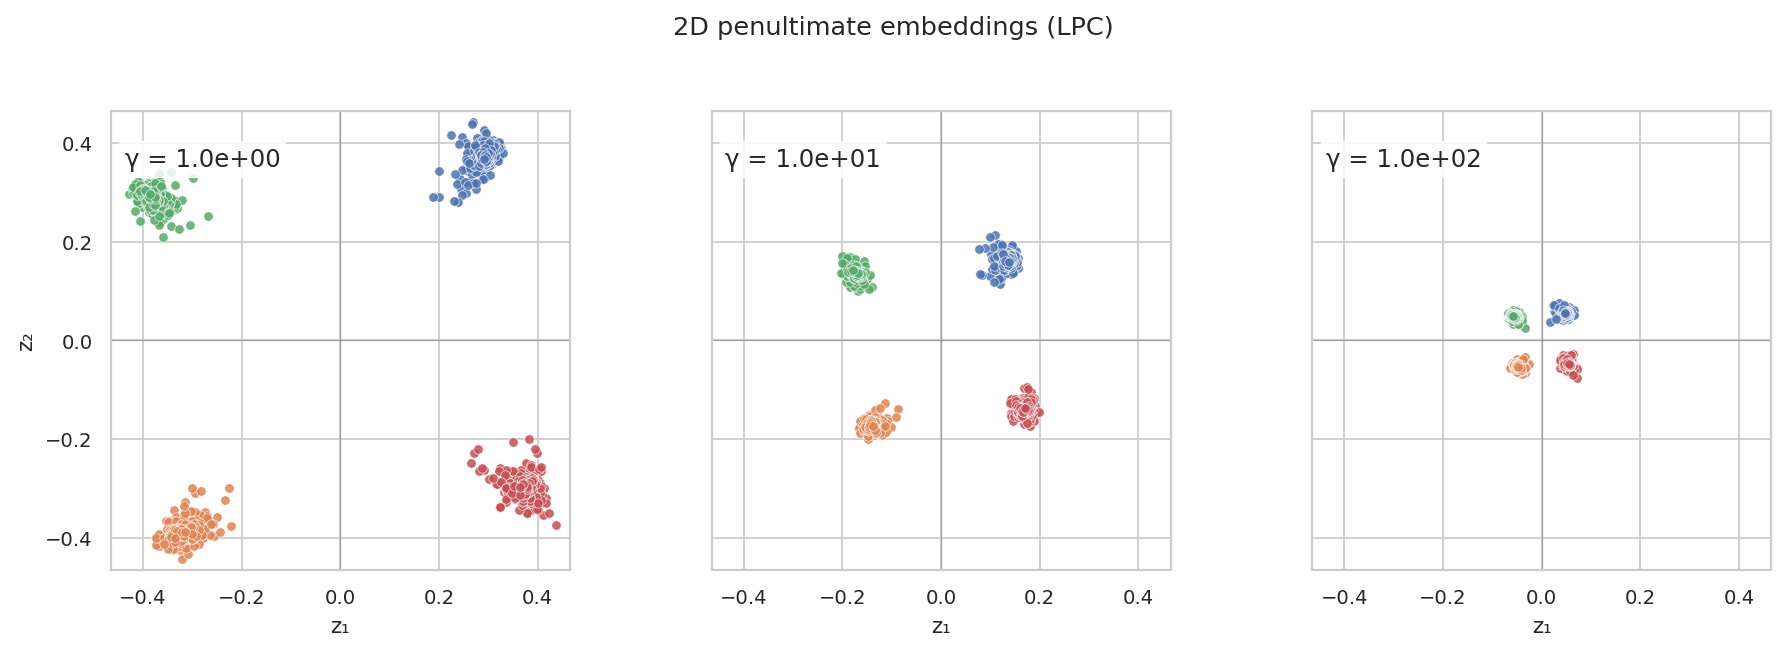

In [6]:
try:
    import seaborn as sns
    sns.set_theme(context='paper', style='whitegrid')
except Exception:
    pass

palette_option = 'deep'

def get_palette(nc, option='tab10'):
    option = (option or 'tab10').lower()
    if option in ('tab10', 'tab20'):
        cmap = plt.get_cmap(option, nc)
        return [cmap(i) for i in range(nc)]
    try:
        import seaborn as sns
        pal_map = {
            'colorblind': sns.color_palette('colorblind', nc),
            'deep': sns.color_palette('deep', nc),
            'set2': sns.color_palette('Set2', nc),
        }
        if option in pal_map:
            return pal_map[option]
    except Exception:
        pass
    if option in ('viridis', 'plasma'):
        cmap = plt.get_cmap(option)
        return [cmap(i / (max(nc - 1, 1))) for i in range(nc)]
    cmap = plt.get_cmap('tab10', nc)
    return [cmap(i) for i in range(nc)]

def annotate_box(ax, text, loc=(0.03, 0.92), ha='left'):
    ax.text(loc[0], loc[1], text,
            transform=ax.transAxes, ha=ha, va='top', fontsize=11,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.85, linewidth=0.5))

def annotate_gamma(ax, gamma, loc=(0.03, 0.92), ha='left'):
    annotate_box(ax, f"γ = {gamma:.1e}", loc=loc, ha=ha)

def annotate_label(ax, text, loc=(0.02, 0.92), ha='left'):
    ax.annotate(text, xy=loc, xycoords='axes fraction', ha=ha, va='top', fontsize=11, fontweight='bold')

def symmetric_limit(latents_dict, order):
    all_Z = [latents_dict[k]['Z'] for k in order if k in latents_dict]
    if not all_Z:
        return 1.0
    Z_concat = np.concatenate(all_Z, axis=0)
    max_val = max(np.abs(Z_concat[:, 0]).max(), np.abs(Z_concat[:, 1]).max())
    pad = 0.05 * max_val if max_val > 0 else 0.5
    lim = max_val + pad
    return lim if lim > 0 else 1.0

def scatter_latents(ax, info, colors, lim, show_ylabel=False, gamma_loc=(0.03, 0.92), gamma_ha='left'):
    Z, y_np = info['Z'], info['y']
    for c in range(n_classes):
        m = (y_np == c)
        ax.scatter(Z[m, 0], Z[m, 1], s=18, alpha=0.85, linewidths=0.3,
                   edgecolors='white', color=colors[c % len(colors)])
    ax.axhline(0, color='gray', lw=0.6, alpha=0.6)
    ax.axvline(0, color='gray', lw=0.6, alpha=0.6)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal', adjustable='box')
    if show_ylabel:
        ax.set_ylabel('z₂')
    ax.set_xlabel('z₁')
    annotate_gamma(ax, info['gamma'], loc=gamma_loc, ha=gamma_ha)

def plot_latents_grid(latents_dict, order):
    fig, axes = plt.subplots(1, len(order), figsize=(12, 4), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.15, wspace=0.12)

    colors = get_palette(n_classes, palette_option)
    lim = symmetric_limit(latents_dict, order)

    for j, key in enumerate(order):
        if key not in latents_dict:
            axes[j].text(0.5, 0.5, f'{key} not recorded', ha='center', va='center')
            axes[j].axis('off')
            continue
        scatter_latents(axes[j], latents_dict[key], colors, lim, show_ylabel=(j == 0))
    fig.suptitle('2D penultimate embeddings (LPC)', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

plot_order_synth = [synth_targets[g] for g in sorted(synth_targets)]
plot_latents_grid(synthetic_latents, plot_order_synth)


## MNIST Training: Binary Encoding Emergence

**Objective**: Demonstrate LPC on a real-world classification task where the high-dimensional penultimate space enables observation of **binary encoding**.

**Architecture**: 784D → [4096,4096] → **8D penultimate** → 10 classes  
**Gamma progression**: $\gamma \in \{10^{-2}, 10^{2}, 10^{6}\}$ spanning 8 orders of magnitude  
**Primary phenomenon**: At extreme $\gamma$ values, the network discovers binary representations as an optimal solution under severe compression.

In [7]:
mnist_transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)

penultimate_dim = 8

def build_mnist_mlp():
    return MLPvanilla(
        input_dims=28 * 28,
        num_classes=10,
        penultimate_nodes=penultimate_dim,
        nodes_head=[4096, 4096],
        activation='SiLU',
        bias_output=True,
    )

def split_param_groups(model, base_lr):
    pen_params = list(model.penultimate_layer.parameters()) if hasattr(model, 'penultimate_layer') else []
    out_params = list(model.output_layer.parameters())
    all_params = list(model.parameters())
    id_pen = set(map(id, pen_params))
    id_out = set(map(id, out_params))
    backbone_params = [p for p in all_params if id(p) not in id_pen and id(p) not in id_out]
    return [
        {'params': backbone_params, 'lr': base_lr},
        {'params': pen_params,    'lr': base_lr},
        {'params': out_params,    'lr': base_lr},
    ]

mnist_hparams = {
    'batch_size': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'lr_min': 1e-6,
    'gamma_init': 1e-4,
    'gamma_factor_1': 2.0,
    'gamma_step_1': 1,
    'gamma_max_1': 1e3,
    'gamma_factor_2': 1.25,
    'gamma_step_2': 5,
    'gamma_max_2': 1e6,
    'gamma_warmup_epochs': 25,
}

mnist_targets = {1e-2: 'gamma_1e-02', 1e2: 'gamma_1e+02', 1e6: 'gamma_1e+06'}

def train_mnist_lpc(cfg, record_targets):
    model = build_mnist_mlp().to(device)
    opt = torch.optim.AdamW(split_param_groups(model, cfg['lr']), weight_decay=cfg['weight_decay'])
    gamma_fn, total_epochs, _, _ = build_gamma_schedule(cfg)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg['batch_size'],
        shuffle=True,
        num_workers=4 if device.type == 'cuda' else 2,
        pin_memory=device.type == 'cuda',
        persistent_workers=(device.type == 'cuda'),
    )
    eval_loader = DataLoader(
        train_ds,
        batch_size=min(1024, len(train_ds)),
        shuffle=False,
        num_workers=2,
        pin_memory=device.type == 'cuda'
    )

    latents = {}
    recorded = {label: False for label in record_targets.values()}
    acc_hist = []

    print(f"Training for {total_epochs} epochs")
    print(f"Device: {device}, Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(1, total_epochs + 1):
        g = gamma_fn(epoch)
        model.train()

        train_loss = 0.0
        num_batches = 0
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            logits = out['x_output']
            pen = out['x_penultimate']
            ce = ce_loss(logits, yb)
            lpc = g * F.mse_loss(pen, torch.zeros_like(pen), reduction='mean')
            loss = ce + lpc
            loss.backward()
            opt.step()
            train_loss += loss.item()
            num_batches += 1

        avg_train_loss = train_loss / num_batches

        model.eval()
        correct = total = 0
        eval_loss = 0.0
        eval_batches = 0
        with torch.no_grad():
            for xb, yb in eval_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                out = model(xb)
                logits = out['x_output']
                pen = out['x_penultimate']
                pred = logits.argmax(dim=1)
                correct += (pred == yb).sum().item()
                total += yb.numel()
                ce = ce_loss(logits, yb)
                lpc = g * F.mse_loss(pen, torch.zeros_like(pen), reduction='mean')
                eval_loss += (ce + lpc).item()
                eval_batches += 1

        acc = correct / total if total > 0 else 0.0
        avg_eval_loss = eval_loss / eval_batches
        acc_hist.append(acc)

        print(f"Epoch {epoch:3d}/{total_epochs} | gamma={g:.2e} | lr={opt.param_groups[0]['lr']:.2e} | train_loss={avg_train_loss:.4f} | eval_loss={avg_eval_loss:.4f} | acc={acc:.4f}")

        for thr, label in record_targets.items():
            if (not recorded[label]) and (g >= thr):
                Z, y_np = collect_latents(model, eval_loader)
                latents[label] = {'Z': Z, 'y': y_np, 'gamma': float(thr)}
                recorded[label] = True

        if g >= cfg['gamma_max_2']:
            print(f"Reached maximum gamma {cfg['gamma_max_2']:.0e}, stopping training")
            break

        if device.type == 'cuda' and epoch % 10 == 0:
            torch.cuda.empty_cache()

    return latents, acc_hist


if run_mnist:
    print("Starting MNIST training with LPC...")
    mnist_latents, mnist_acc_hist = train_mnist_lpc(mnist_hparams, mnist_targets)
    save_latents(mnist_latents, mnist_cache)
    print(f"Training completed! Final accuracy: {mnist_acc_hist[-1]:.4f}")
    print(f"Saved MNIST latents to {mnist_cache}")
else:
    mnist_latents = load_latents(mnist_cache)
    mnist_acc_hist = None
    print(f"Loaded MNIST latents from {mnist_cache}")


Loaded MNIST latents from results/lpc_ffn_demo/mnist_latents.npz


## MNIST Results: Emergence of Binary Encoding

**Histograms show the distribution of all penultimate activations** (across all 8 dimensions and all 60,000 training samples).

**Progression demonstrates**:
- **$\gamma = 10^{-2}$**: Normal distributed activations around zero
- **$\gamma = 10^{2}$**: Increased concentration toward zero  
- **$\gamma = 10^{6}$**: Activations concentrate at discrete points opposite to each other relative to the origin

This binary encoding emerges naturally as the optimal solution when extreme compression forces the network to use minimal representational volume while preserving discriminative power.

Generating MNIST binary encoding visualization...


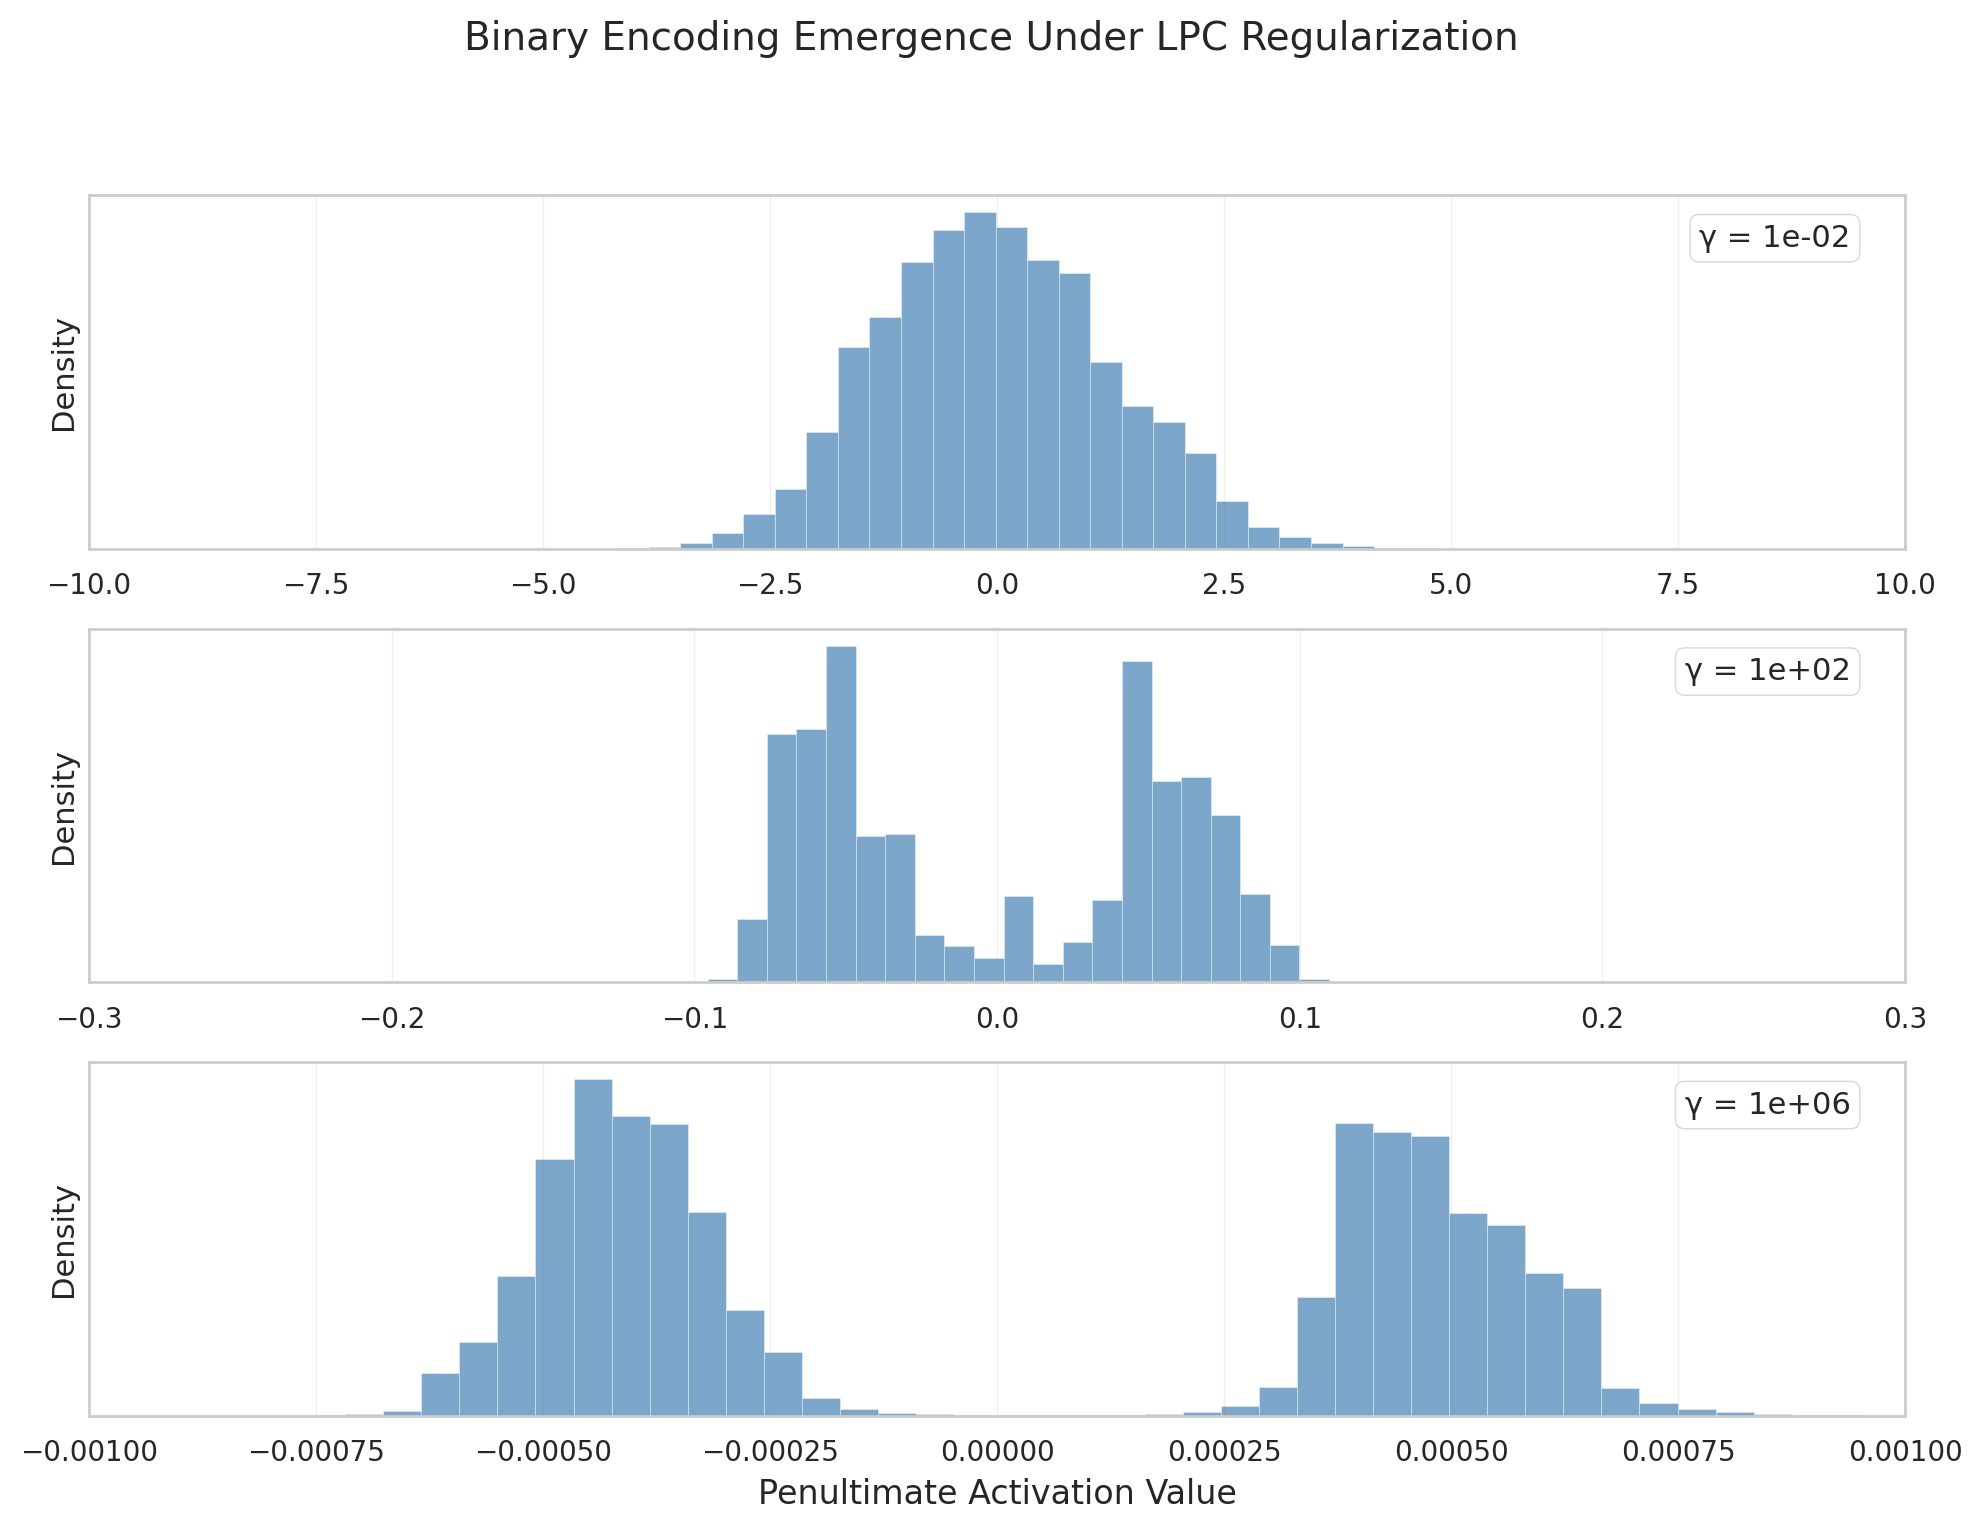

In [9]:
# MNIST Visualization: Generate Binary Encoding Figure

try:
    import seaborn as sns
    sns.set_theme(context='paper', style='whitegrid')
except ImportError:
    pass

plt.rcParams.update({
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'axes.titlesize': 13,
    'axes.labelsize': 12, 
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'DejaVu Sans',
    'mathtext.fontset': 'dejavusans'
})

def annotate_gamma(ax, gamma, loc=(0.03, 0.92), ha='left', fontsize=11):
    """Add gamma value annotation with clean styling."""
    ax.text(loc[0], loc[1], f"γ = {gamma:.0e}", 
            transform=ax.transAxes, ha=ha, va='top', fontsize=fontsize,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, 
                     edgecolor='lightgray', linewidth=0.5))

def plot_mnist_histograms(latents_dict, order, xlims=None):
    """Plot MNIST histograms showing binary encoding emergence."""
    if xlims is None:
        xlims = [(-10, 10), (-0.3, 0.3), (-0.001, 0.001)]
    
    fig, axes = plt.subplots(len(order), 1, figsize=(10, 8), sharex=False)
    plt.subplots_adjust(hspace=0.35)
    
    for i, label in enumerate(order):
        ax = axes[i]
        if label not in latents_dict:
            ax.text(0.5, 0.5, f'{label} not recorded', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12, style='italic')
            ax.axis('off')
            continue
            
        vals = latents_dict[label]['Z'].reshape(-1)
        gamma = latents_dict[label]['gamma']
        
        # Enhanced histogram styling
        ax.hist(vals, bins=120, color='steelblue', alpha=0.7, 
               edgecolor='white', linewidth=0.2, density=True)
        
        # Custom x-limits for each subplot
        if i < len(xlims):
            ax.set_xlim(xlims[i])
        
        # Styling and annotations
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.set_ylabel('Density', fontsize=11)
        
        # Gamma annotation
        annotate_gamma(ax, gamma, loc=(0.97, 0.92), ha='right')
        
        # Remove y-axis ticks for cleaner look
        ax.set_yticks([])
        
        if i == len(order) - 1:
            ax.set_xlabel('Penultimate Activation Value', fontsize=12)
    
    fig.suptitle('Binary Encoding Emergence Under LPC Regularization', fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    return fig

# Generate MNIST histogram figure
mnist_order = [mnist_targets[g] for g in sorted(mnist_targets)]

print("Generating MNIST binary encoding visualization...")
fig_mnist = plot_mnist_histograms(mnist_latents, mnist_order,
                                 xlims=[(-10, 10), (-0.3, 0.3), (-0.001, 0.001)])
plt.show()
